In [1]:
!pip install --quiet transformers accelerate datasets evaluate peft bitsandbytes

In [ ]:
from datasets import load_dataset

# Food Datset
dataset1 = load_dataset("food101", split="train[:12000]")

In [3]:
dataset1

Dataset({
    features: ['image', 'label'],
    num_rows: 10000
})

In [ ]:
# Human Actions Dataset
dataset2 = load_dataset("Bingsu/Human_Action_Recognition")

In [5]:
dataset2

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 12600
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 5400
    })
})

In [6]:
# Changing the column name of dataset2 from labels to label for same column as dataset1
dataset2 = dataset2.rename_column('labels', 'label')
dataset2

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 12600
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 5400
    })
})

In [ ]:
from datasets import DatasetDict

# splitting the dataset1 into train and test and then creating a DatasetDict 
dataset1_train, dataset1_test = dataset1.train_test_split(test_size=0.1).values()

dataset1 = DatasetDict({'train': dataset1_train, 'test': dataset1_test})

In [9]:
dataset1['train']

Dataset({
    features: ['image', 'label'],
    num_rows: 9000
})

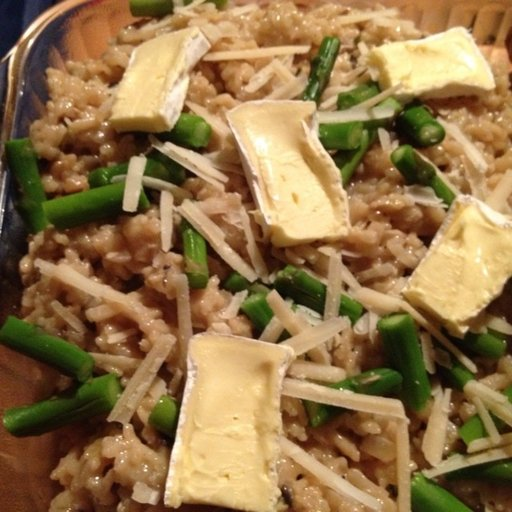

In [10]:
dataset1['train'][10]['image']

In [14]:
dataset2['train'][0]['image'].size

(240, 160)

In [12]:
dataset2['train'].features['label'].names

['calling',
 'clapping',
 'cycling',
 'dancing',
 'drinking',
 'eating',
 'fighting',
 'hugging',
 'laughing',
 'listening_to_music',
 'running',
 'sitting',
 'sleeping',
 'texting',
 'using_laptop']

In [15]:
# create mappings for id to label and viceversa for a dataset
def create_label_mappings(dataset):
    label2id, id2label = dict(), dict()
    for i, label in enumerate(dataset.features["label"].names):
        label2id[label] = i
        id2label[i] = label 

    return label2id, id2label


dataset1_label2id, dataset1_id2label = create_label_mappings(dataset1['train'])
dataset2_label2id, dataset2_id2label = create_label_mappings(dataset2['train'])

In [23]:

model_configs = {
    "model1": {
        "train_data": dataset['train'],
        "test_data": dataset1['test'],
        "label2id": dataset1_label2id,
        "id2label": dataset1_id2label,
        "epochs": 3,
        "path": "./lora-food-model"
    },
    "model2": {
        "train_data": dataset2['train'],
        "test_data": dataset2['test'],
        "label2id": dataset2_label2id,
        "id2label": dataset2_id2label,
        "epochs": 3,
        "path": "./lora-human-model"
    },
}
     

In [55]:
model_configs['model2']

{'train_data': Dataset({
     features: ['image', 'label'],
     num_rows: 12600
 }),
 'test_data': Dataset({
     features: ['image', 'label'],
     num_rows: 5400
 }),
 'label2id': {'calling': 0,
  'clapping': 1,
  'cycling': 2,
  'dancing': 3,
  'drinking': 4,
  'eating': 5,
  'fighting': 6,
  'hugging': 7,
  'laughing': 8,
  'listening_to_music': 9,
  'running': 10,
  'sitting': 11,
  'sleeping': 12,
  'texting': 13,
  'using_laptop': 14},
 'id2label': {0: 'calling',
  1: 'clapping',
  2: 'cycling',
  3: 'dancing',
  4: 'drinking',
  5: 'eating',
  6: 'fighting',
  7: 'hugging',
  8: 'laughing',
  9: 'listening_to_music',
  10: 'running',
  11: 'sitting',
  12: 'sleeping',
  13: 'texting',
  14: 'using_laptop'},
 'epochs': 3,
 'path': './lora-human-model'}

In [17]:
from transformers import AutoImageProcessor

model_checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(model_checkpoint, use_fast=True)

2024-07-28 18:10:48.800313: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-28 18:10:48.800428: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-28 18:10:48.938568: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

In [18]:
image_processor

ViTImageProcessorFast {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessorFast",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [25]:
from torchvision.transforms import CenterCrop, Compose, Normalize, Resize, ToTensor

# pipeline for preprocessing images to get same shape and scaling
preprocess_image = Compose([
    Resize(image_processor.size["height"]),
    CenterCrop(image_processor.size["height"]),
    ToTensor(),
    Normalize(mean=image_processor.image_mean, std=image_processor.image_std),
])

# function to apply above preprocessing to a batch (train or test)
def preprocess(batch):
    batch["pixel_values"] = [
        preprocess_image(image.convert("RGB")) for image in batch["image"]
    ]
    return batch

In [25]:
# applying the preprocess fucntion to both datasets
for model in model_configs.values():
    model["train_data"].set_transform(preprocess)
    model["test_data"].set_transform(preprocess)

In [28]:
import os 
import torch
from peft import PeftModel, LoraConfig, get_peft_model
from transformers import AutoModelForImageClassification, BitsAndBytesConfig

In [ ]:
def print_model_size(path):
    size = 0
    for f in os.scandir(path):
        size += os.path.getsize(f)

    print(f"Model Size: {(size / 1e6):.2} MB")


def print_trainable_parameters(model, label):
    params, trainable = 0, 0
    
    for _, p in model.named_parameters():
        params += p.numel()
        trainable += p.numel() if p.requires_grad else 0

    print(f"{label} trainable parameters: {trainable:,}/{params:,} ({100 * trainable / params:.2f}%)")

In [29]:
import evaluate
import numpy as np

metric = evaluate.load("accuracy")

'''
# if you want to use quantized lora fine-tuning
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
'''

def data_collator(batch):

    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    labels = torch.tensor([item["label"] for item in batch])
    return {"pixel_values": pixel_values, "labels": labels}


def compute_metrics(eval_pred):

    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)


def get_base_model(label2id, id2label):
    return AutoModelForImageClassification.from_pretrained(
        model_checkpoint,
        label2id=label2id,
        id2label=id2label,
        ignore_mismatched_sizes=True,
#         quantization_config=bnb_config,
#         device_map="auto",
    )


def build_lora_model(label2id, id2label):
    base_model = get_base_model(label2id, id2label)
    print_trainable_parameters(model, label="Base Model")

    config = LoraConfig(
        r=16,
        lora_alpha=16,
        target_modules=["query", "value"],
        lora_dropout=0.1,
        bias="none",
        modules_to_save=["classifier"],
    )

    lora_model = get_peft_model(base_model, config)
    print_trainable_parameters(lora_model, label="LoRA")

    return lora_model

In [31]:

from transformers import TrainingArguments

batch_size = 64
training_arguments = TrainingArguments(
    output_dir="./model-checkpoints",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-3,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=4,
    fp16=True,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    label_names=["labels"],
)

In [ ]:

from transformers import Trainer

for model in model_configs.values():
    training_arguments.num_train_epochs = model["epochs"]
    
    trainer = Trainer(
        build_lora_model(model["label2id"], model["id2label"]),
        training_arguments,
        train_dataset=model["train_data"],
        eval_dataset=model["test_data"],
        tokenizer=image_processor,
        compute_metrics=compute_metrics,
        data_collator=data_collator,
    )

    results = trainer.train()
    evaluation_results = trainer.evaluate(model['test_data'])
    print(f"Evaluation accuracy: {evaluation_results['eval_accuracy']}")

    # save the fine-tuned model to disk.
    trainer.save_model(model["path"])
    print_model_size(model["path"])

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Base model trainable parameters: 85,876,325/85,876,325 (100.00%)
LoRA trainable parameters: 667,493/86,543,818 (0.77%)


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
0,0.217600,0.213298,0.928000


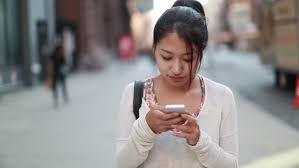

In [64]:
model_configs['model2']['train_data'][120]['image']

In [34]:
# Doing the inference
def build_inference_model(label2id, id2label, lora_adapter_path):
    base_model = get_base_model(label2id, id2label)
    return PeftModel.from_pretrained(base_model, lora_adapter_path)


def predict_image_class(image, model, image_processor):
    encoding = image_processor(image.convert("RGB"), return_tensors="pt")
    with torch.no_grad():
        outputs = model(**encoding)
        logits = outputs.logits

    class_index = logits.argmax(-1).item()
    return model.config.id2label[class_index]


In [65]:
food_model = build_inference_model(dataset1_label2id, dataset1_id2label, "lora-food-model")
food_image_processor = AutoImageProcessor.from_pretrained("lora-food-model")

human_model = build_inference_model(dataset2_label2id, dataset2_id2label, "lora-human-model")
human_image_processor = AutoImageProcessor.from_pretrained("lora-human-model")


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


running
running


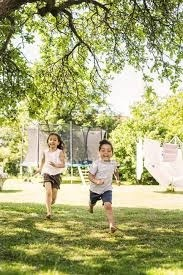

In [91]:

img = dataset2['train'][1234]['image']
print(dataset2_id2label[dataset2['train'][1234]['label']])
print(predict_image_class(img, human_model, human_image_processor))
img

In [72]:
def calculate_accuracy(dataset, id2label, model, processor):
    correct = 0
    incorrect = 0
    for i in range(len(dataset['test'])):
        img = dataset['test'][i]['image']
        label = dataset['test'][i]['label']
        pred = predict(img, model, processor)
        
        if id2label[label] == pred:
            correct += 1
        else:
            incorrect += 1
            
    return correct, incorrect, (correct / (len(dataset['test'])))

correct, incorrect, accuracy = calculate_accuracy(dataset2, human_model, human_image_processor)

In [96]:
!zip -r lora-human.zip lora-human-model

  adding: lora-human-model/ (stored 0%)
  adding: lora-human-model/training_args.bin (deflated 51%)
  adding: lora-human-model/preprocessor_config.json (deflated 46%)
  adding: lora-human-model/adapter_config.json (deflated 52%)
  adding: lora-human-model/adapter_model.safetensors (deflated 8%)
  adding: lora-human-model/README.md (deflated 66%)


In [97]:
!ls

file.zip	 lora-food.zip	   lora-human.zip     wandb
lora-food-model  lora-human-model  model-checkpoints


In [100]:
from IPython.display import FileLink
FileLink(r'lora-human.zip')

/kaggle/working/lora-human.zip